In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
import upsetplot
from functools import reduce
import warnings
import glob
warnings.filterwarnings('ignore')


In [21]:
## Data loading

In [2]:
ll

total 236
-rw-rw-r--  1 priesgo 176927 Jun 14 16:23 analysis.ipynb
drwxrwxr-x 24 priesgo   4096 Jun  9 13:44 condaenv/
-rw-rw-r--  1 priesgo  13212 Jun 12 20:29 conda.environment
drwxrwxr-x  2 priesgo   4096 Jun 14 16:21 ERR5229917/
drwxrwxr-x  2 priesgo   4096 Jun 14 16:21 ERR5397623/
drwxrwxr-x  2 priesgo   4096 Jun 14 16:21 ERR5401235/
drwxrwxr-x  2 priesgo   4096 Jun 14 16:21 ERR5409159/
drwxrwxr-x  2 priesgo   4096 Jun 14 16:21 ERR5514762/
-rwxrwxr-x  1 priesgo    105 Jun  8 06:53 ivar2tab*
drwxrwxr-x  7 priesgo   4096 Jun 14 16:12 old/
-rwxrwxr-x  1 priesgo    974 Jun 14 16:01 run.sh*
-rwxrwxr-x  1 priesgo    123 Jun 14 16:20 vcf2tab*
-rwxrwxr-x  1 priesgo    143 Jun 14 16:18 vcf2tab_filter*


In [5]:
%%bash
find . -name *.lofreq*.vcf.tab | grep -v old

./ERR5514762/ERR5514762.lofreq.normalized.annotated.vcf.tab
./ERR5401235/ERR5401235.lofreq.normalized.annotated.vcf.tab
./ERR5409159/ERR5409159.lofreq.normalized.annotated.vcf.tab
./ERR5397623/ERR5397623.lofreq.normalized.annotated.vcf.tab
./ERR5229917/ERR5229917.lofreq.normalized.annotated.vcf.tab


In [37]:
def load_sample(file_name, sample_name, caller):
    data = pd.read_csv(file_name, sep="\t", names=["chromosome", "position", "reference", "alternate", "filter", "af"])
    data["sample"] = sample_name
    data["caller"] = caller
    data["indel"] = data[["reference", "alternate"]].apply(lambda x: len(x[0]) > 1 or len(x[1]) > 1, axis=1)
    data["filter"].fillna("PASS", inplace=True)
    data["filter"] = data["filter"].transform(lambda f: "PASS" if f == "." else f)
    return data

In [24]:
def load_samples(pattern, caller):
    lofreqs = []
    for variants_file in glob.glob(pattern):
        lofreqs.append(load_sample(variants_file, sample_name=variants_file.split("/")[0], caller=caller))
    return pd.concat(lofreqs)

In [25]:
lofreq = load_samples(pattern='ERR*/*.lofreq.normalized.annotated.vcf.tab', caller='LoFreq')
lofreq.head()

,chromosome,position,reference,alternate,filter,af,sample,caller,indel
0,MN908947.3,71,C,G,LOW_FREQUENCY,0.011009,ERR5514762,LoFreq,False
1,MN908947.3,241,C,T,PASS,0.965035,ERR5514762,LoFreq,False
2,MN908947.3,306,T,TC,LOW_FREQUENCY,0.016000,ERR5514762,LoFreq,True
3,MN908947.3,330,A,G,LOW_FREQUENCY,0.041139,ERR5514762,LoFreq,False
4,MN908947.3,370,G,C,LOW_FREQUENCY,0.002400,ERR5514762,LoFreq,False


In [38]:
gatk = load_samples(pattern='ERR*/*.gatk.normalized.annotated.vcf.tab', caller='GATK')
gatk.head()

,chromosome,position,reference,alternate,filter,af,sample,caller,indel
0,MN908947.3,241,C,T,PASS,NaN,ERR5514762,GATK,False
1,MN908947.3,913,C,T,PASS,NaN,ERR5514762,GATK,False
2,MN908947.3,2453,C,T,PASS,NaN,ERR5514762,GATK,False
3,MN908947.3,3037,C,T,PASS,NaN,ERR5514762,GATK,False
4,MN908947.3,5259,C,CAGGCACAGG,PASS,NaN,ERR5514762,GATK,True


In [27]:
bcftools = load_samples(pattern='ERR*/*.bcftools.normalized.annotated.vcf.tab', caller='BCFtools')
bcftools.head()

,chromosome,position,reference,alternate,filter,af,sample,caller,indel
0,MN908947.3,241,C,T,PASS,NaN,ERR5514762,BCFtools,False
1,MN908947.3,913,C,T,PASS,NaN,ERR5514762,BCFtools,False
2,MN908947.3,2453,C,T,PASS,NaN,ERR5514762,BCFtools,False
3,MN908947.3,3037,C,T,PASS,NaN,ERR5514762,BCFtools,False
4,MN908947.3,5087,A,G,PASS,NaN,ERR5514762,BCFtools,False


In [20]:
%%bash
find . -name *.ivar.tab

./ERR5514762/ERR5514762.ivar.tab
./ERR5401235/ERR5401235.ivar.tab
./ERR5409159/ERR5409159.ivar.tab
./ERR5397623/ERR5397623.ivar.tab
./ERR5229917/ERR5229917.ivar.tab
./old/ERR5514762/ERR5514762.preprocessed.ivar.tab
./old/ERR5401235/ERR5401235.preprocessed.ivar.tab
./old/ERR5409159/ERR5409159.preprocessed.ivar.tab
./old/ERR5397623/ERR5397623.preprocessed.ivar.tab
./old/ERR5229917/ERR5229917.preprocessed.ivar.tab


In [34]:
ivar = load_samples(pattern='ERR*/*.ivar.tab', caller='iVar')
ivar.head()

,chromosome,position,reference,alternate,filter,af,sample,caller,indel
0,MN908947.3,37,C,G,PASS,NaN,ERR5514762,iVar,False
1,MN908947.3,38,A,G,PASS,NaN,ERR5514762,iVar,False
2,MN908947.3,241,C,T,PASS,NaN,ERR5514762,iVar,False
3,MN908947.3,330,A,G,PASS,NaN,ERR5514762,iVar,False
4,MN908947.3,330,A,G,PASS,NaN,ERR5514762,iVar,False


In [40]:
all_callers = pd.concat([lofreq, gatk, bcftools, ivar])

In [ ]:
## Visualization methods

In [28]:
def plot_upset(data, figure_name, annotations=[]):
    table = data.groupby(['chromosome', 'position', 'reference', 'alternate', 'sample', 'caller']).size().unstack(fill_value=0).astype(bool)
    all_afs = data.set_index(['chromosome', 'position', 'reference', 'alternate', 'sample'])
    all_afs = all_afs.loc[~all_afs.index.duplicated(keep='first')]
    table = table.reset_index().join(all_afs, how='inner', on=['chromosome', 'position', 'reference', 'alternate', 'sample'])
    table = table.set_index(list(set(data.caller)))
    upset = upsetplot.UpSet(table, subset_size='count', intersection_plot_elements=2, facecolor='steelblue', show_counts=True, element_size=50)
    colors= ['orange', 'forestgreen', 'indianred']
    for a, c in zip(annotations, colors):
            upset.add_catplot(value=a, kind='strip', color=c, alpha=0.4)
    fig = plt.figure(figsize=(300,100))
    upset.plot(fig=fig)
    fig.savefig(figure_name)
    return upset, table

In [ ]:
def lineplot_attribute_by_caller_and_sample(data, attribute, title, yaxis_label, figure_name):

    gridkw = dict(height_ratios=[4, 1], hspace=0)
    fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw=gridkw, figsize=(15, 10))

    data = data.sort_values(['htc', 'sample'])
    g = sns.lineplot(x="sample", y=attribute, hue="caller", style='purity_level', markers=True, sort=False, data=data, ax=ax1)
    g = sns.lineplot(x="sample", y="htc", style='purity_level', color='grey', markers=True, sort=False, legend=False, data=data, ax=ax2)
    ax1.set_xlabel(None)
    ax1.set_xticklabels([])
    for label in ax2.get_xticklabels():
        label.set_rotation(45)
    ax1.set_title(title)
    ax1.set_ylabel(yaxis_label)
    ax2.set_ylabel("HTC")
    ax2.set_xlabel(None)
    fig.savefig(figure_name)

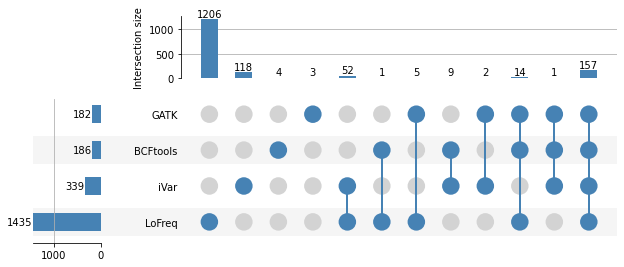

In [30]:
upset, table = plot_upset(data=all_callers, figure_name='figure_00_all_variants_upset.png')

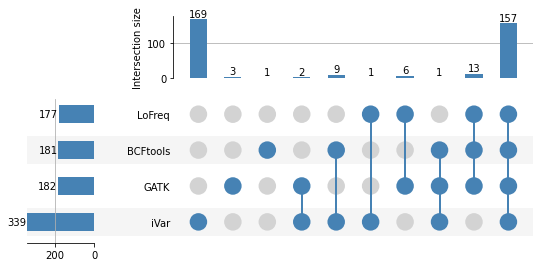

In [41]:
upset, table = plot_upset(data=all_callers[all_callers["filter"] == "PASS"], figure_name='figure_00_all_variants_PASS.png')

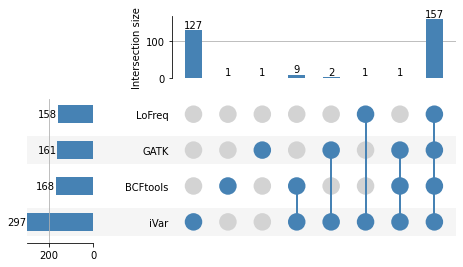

In [42]:
upset, table = plot_upset(data=all_callers[(all_callers["filter"] == "PASS") & (all_callers.indel == False)], figure_name='figure_00_all_variants_PASS_only_snps_upset.png')

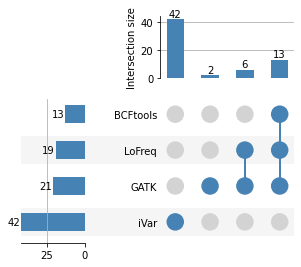

In [43]:
upset, table = plot_upset(data=all_callers[(all_callers["filter"] == "PASS") & (all_callers.indel == True)], figure_name='figure_00_all_variants_PASS_only_indels_upset.png')

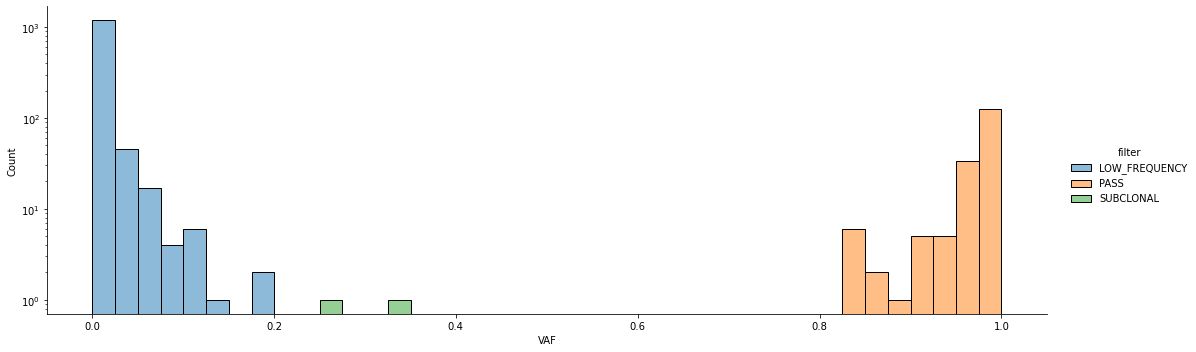

In [71]:
fig = sns.displot(data=lofreq, x="af", hue="filter", bins=40, aspect=3)
ax = fig.ax
ax.set_yscale('log')
ax.set_xlabel("VAF")
fig.savefig("figure_01_lofreq_vaf.png")

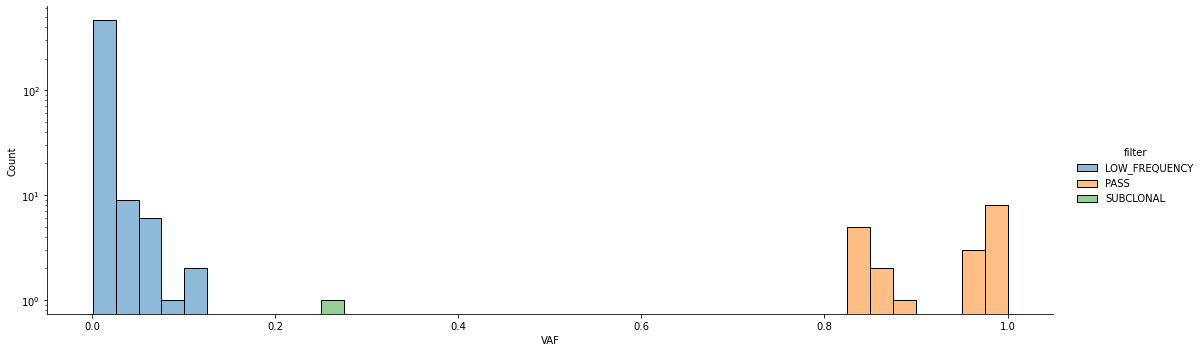

In [72]:
fig = sns.displot(data=lofreq[lofreq.indel], x="af", hue="filter", bins=40, aspect=3)
ax = fig.ax
ax.set_yscale('log')
ax.set_xlabel("VAF")
fig.savefig("figure_01_lofreq_vaf_indels.png")

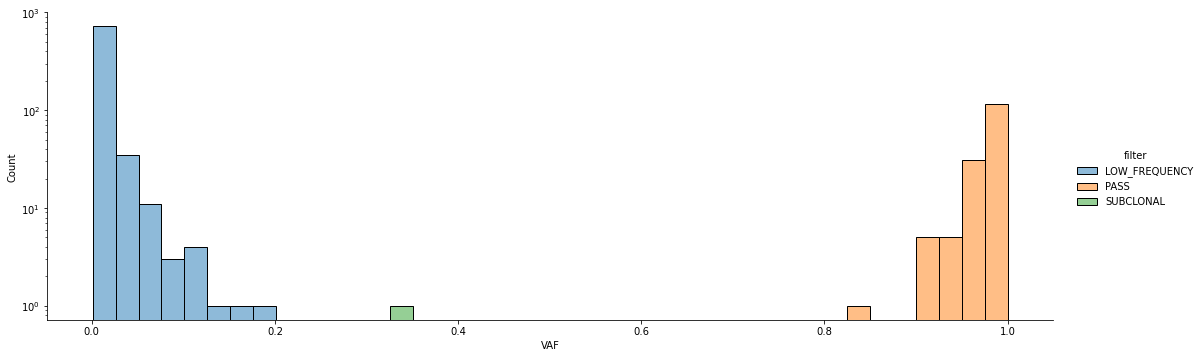

In [73]:
fig = sns.displot(data=lofreq[~lofreq.indel], x="af", hue="filter", bins=40, aspect=3)
ax = fig.ax
ax.set_yscale('log')
ax.set_xlabel("VAF")
fig.savefig("figure_01_lofreq_vaf_snvs.png")

In [74]:
lofreq[lofreq["filter"] == "SUBCLONAL"]

,chromosome,position,reference,alternate,filter,af,sample,caller,indel
238,MN908947.3,28253,CA,C,SUBCLONAL,0.269058,ERR5514762,LoFreq,True
239,MN908947.3,28254,A,C,SUBCLONAL,0.346939,ERR5514762,LoFreq,False


In [76]:
problematic_sites = load_sample("problematic_sites_sarsCov2.vcf.tab", "problematic_sites", "problematic_sites")
problematic_sites.head()

,chromosome,position,reference,alternate,filter,af,sample,caller,indel
0,MN908947.3,1,A,.,mask,NaN,problematic_sites,problematic_sites,False
1,MN908947.3,2,T,.,mask,NaN,problematic_sites,problematic_sites,False
2,MN908947.3,3,T,.,mask,NaN,problematic_sites,problematic_sites,False
3,MN908947.3,4,A,.,mask,NaN,problematic_sites,problematic_sites,False
4,MN908947.3,5,A,.,mask,NaN,problematic_sites,problematic_sites,False


In [90]:
all_callers_with_problematic = pd.merge(left=all_callers, right=problematic_sites[["position", "filter"]], on=["position"], how="left", suffixes=("", "_problematic"))
all_callers_with_problematic.fillna("", inplace=True)
all_callers_with_problematic.head()

,chromosome,position,reference,alternate,filter,af,sample,caller,indel,filter_problematic
0,MN908947.3,71,C,G,LOW_FREQUENCY,0.011009,ERR5514762,LoFreq,False,
1,MN908947.3,241,C,T,PASS,0.965035,ERR5514762,LoFreq,False,
2,MN908947.3,306,T,TC,LOW_FREQUENCY,0.016,ERR5514762,LoFreq,True,
3,MN908947.3,330,A,G,LOW_FREQUENCY,0.041139,ERR5514762,LoFreq,False,
4,MN908947.3,370,G,C,LOW_FREQUENCY,0.0024,ERR5514762,LoFreq,False,


In [93]:
all_callers_with_problematic.groupby(["caller", "filter", "filter_problematic"])[["position"]].count()

position
caller   filter        filter_problematic          
BCFtools LOW_FREQUENCY                            4
         PASS                                   166
                       caution                   15
         SUBCLONAL                                1
GATK     PASS                                   168
                       caution                   13
                       mask                       1
LoFreq   LOW_FREQUENCY                         1229
                       caution                   17
                       mask                      10
         PASS                                   165
                       caution                   12
         SUBCLONAL                                1
                       mask                       1
iVar     PASS                                   410
                       caution                   20
                       mask                      11